In [1]:
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch.nn.functional as F
import datetime

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

from torchvision import datasets, transforms
data_path = 'data/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

100%|██████████| 170498071/170498071 [00:23<00:00, 7262591.60it/s] 


Extracting data/cifar-10-python.tar.gz to data/


In [3]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [4]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [5]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cpu.


In [6]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    loss_train_norm = np.zeros(n_epochs)
    loss_val_norm = np.zeros(n_epochs)
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        loss_val = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        
        loss_train_norm[epoch-1] = loss_train / len(train_loader)

        for imgs, labels in val_loader:
            imgs = imgs.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            loss_val += loss.item()

        loss_val_norm[epoch-1] = loss_val / len(val_loader)

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train_norm[epoch-1]))
            print('{} Epoch {}, Validation loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_val_norm[epoch-1]))
            
    return loss_train_norm, loss_val_norm

In [7]:
def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

In [8]:
# first the 3x3 convolution kernel 

class Net3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

model3 = Net3()  #  <2>
torch.save(model3.state_dict(), data_path + 'birds_vs_airplanes.pt')

loaded_model = Net3().to(device=device)
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt',
                                        map_location=device))

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=True)


model3 = Net3().to(device=device)
optimizer = optim.SGD(model3.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

losstrain3, lossval3 = training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model3,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader
)

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

all_acc_dict["baseline"] = validate(model3, train_loader, val_loader)

print(sum(p.numel() for p in model3.parameters()))

2023-06-06 15:25:09.432300 Epoch 1, Training loss 0.5663522683131467
2023-06-06 15:25:09.432300 Epoch 1, Validation loss 0.47924484964460135
2023-06-06 15:25:33.522137 Epoch 10, Training loss 0.336981445930566
2023-06-06 15:25:33.522137 Epoch 10, Validation loss 0.3319766060449183
2023-06-06 15:25:59.182930 Epoch 20, Training loss 0.29806143463037577
2023-06-06 15:25:59.182930 Epoch 20, Validation loss 0.3063385779969394
2023-06-06 15:26:25.483136 Epoch 30, Training loss 0.27216228766805806
2023-06-06 15:26:25.483136 Epoch 30, Validation loss 0.2877007140778005
2023-06-06 15:26:53.127462 Epoch 40, Training loss 0.244968799553859
2023-06-06 15:26:53.127462 Epoch 40, Validation loss 0.2711747440043837
2023-06-06 15:27:21.005286 Epoch 50, Training loss 0.2269515977923278
2023-06-06 15:27:21.005286 Epoch 50, Validation loss 0.2762644477188587
2023-06-06 15:27:50.146067 Epoch 60, Training loss 0.20948709395660717
2023-06-06 15:27:50.146067 Epoch 60, Validation loss 0.2691482831723988
2023-0

In [9]:
# now the 5x5 convolution kernel

class Net5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
model5 = Net5()  #  <2>
torch.save(model5.state_dict(), data_path + 'birds_vs_airplanes.pt')

loaded_model = Net5().to(device=device)
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt',
                                        map_location=device))

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=True)

model5 = Net5().to(device=device)
optimizer = optim.SGD(model5.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

losstrain5, lossval5 = training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model5,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader
)

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model5, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model5(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

all_acc_dict["baseline"] = validate(model5, train_loader, val_loader)

print(sum(p.numel() for p in model5.parameters()))

2023-06-06 15:30:43.752554 Epoch 1, Training loss 0.57756399064307
2023-06-06 15:30:43.752554 Epoch 1, Validation loss 0.48779772501438856
2023-06-06 15:31:10.673742 Epoch 10, Training loss 0.3165200546288946
2023-06-06 15:31:10.673742 Epoch 10, Validation loss 0.33397193858399987
2023-06-06 15:31:40.633046 Epoch 20, Training loss 0.27387552846009566
2023-06-06 15:31:40.633046 Epoch 20, Validation loss 0.29087954526767135
2023-06-06 15:32:10.654184 Epoch 30, Training loss 0.24597254376502553
2023-06-06 15:32:10.654184 Epoch 30, Validation loss 0.29427074547857046
2023-06-06 15:32:40.316326 Epoch 40, Training loss 0.22104166082705662
2023-06-06 15:32:40.316326 Epoch 40, Validation loss 0.2776766971219331
2023-06-06 15:33:11.821228 Epoch 50, Training loss 0.19761831071346428
2023-06-06 15:33:11.821228 Epoch 50, Validation loss 0.2781954607926309
2023-06-06 15:33:42.499576 Epoch 60, Training loss 0.17342496924339587
2023-06-06 15:33:42.499576 Epoch 60, Validation loss 0.4015896669588983
2

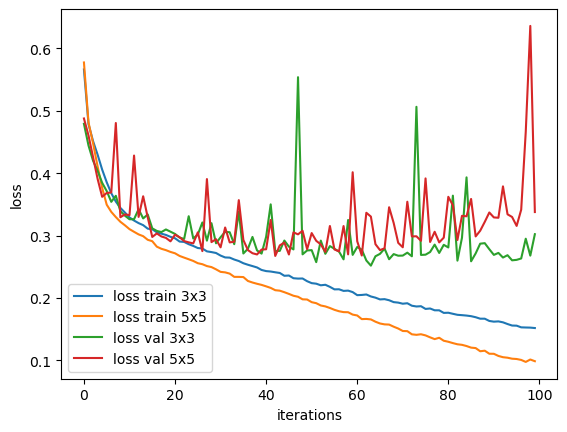

In [10]:
plt.plot(losstrain3)
plt.plot(losstrain5)
plt.plot(lossval3)
plt.plot(lossval5)
plt.legend(['loss train 3x3', 'loss train 5x5', 'loss val 3x3', 'loss val 5x5'])
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

1. Die Anzahl der freien Parameter im Modell erhöhen sich bei der Vergrößerung des Faltungskernels von 3x3 auf 5x5

2. Mit dem 5x5 Kernel verschlechtert sich das Overfitting, weil sich der trainings loss geringer wird aber der validation loss nicht.

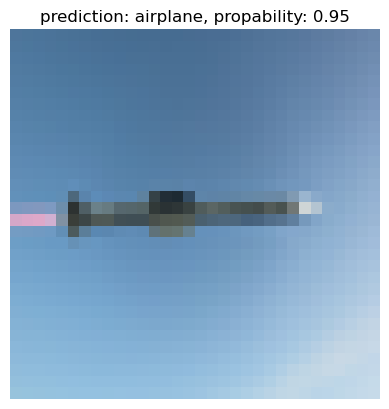

In [12]:
from PIL import Image

image = Image.open('data/Astra_MK-1_closeup.jpg')
image = image.resize((32, 32))
image = np.array(image)

tensor_image = torch.from_numpy(image)
tensor_image = tensor_image.permute(2, 0, 1).float()

output = model5(tensor_image)
output = F.softmax(output,dim=1)
confi, predicted = torch.max(output, dim=1) 

plt.imshow(image)
plt.title(f"prediction: {class_names[predicted.item()]}, propability: {confi.item():.2f}")
plt.axis('off')
plt.show()